In [1]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')   
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/notebooks' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)

data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features.nc'
print(f"Buscando archivo en: {data_file}")

Entorno configurado. Usando ruta base: ..
Buscando archivo en: ../data/output/complete_dataset_with_features.nc


ℹ️ No se detectó GPU, usando CPU


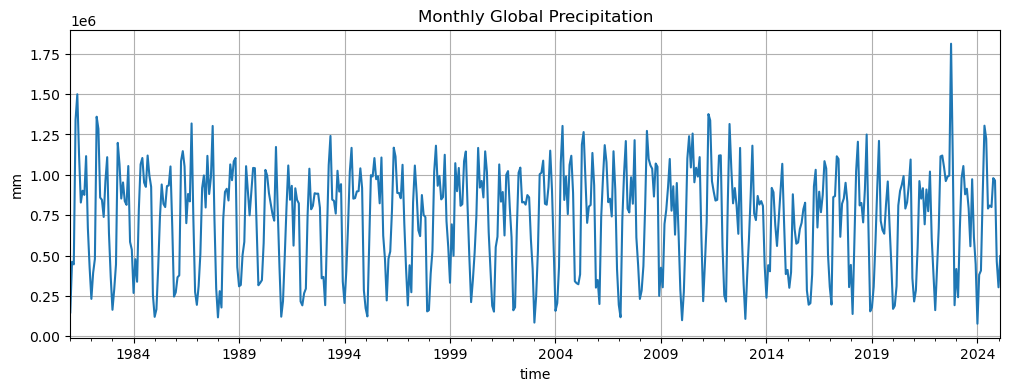

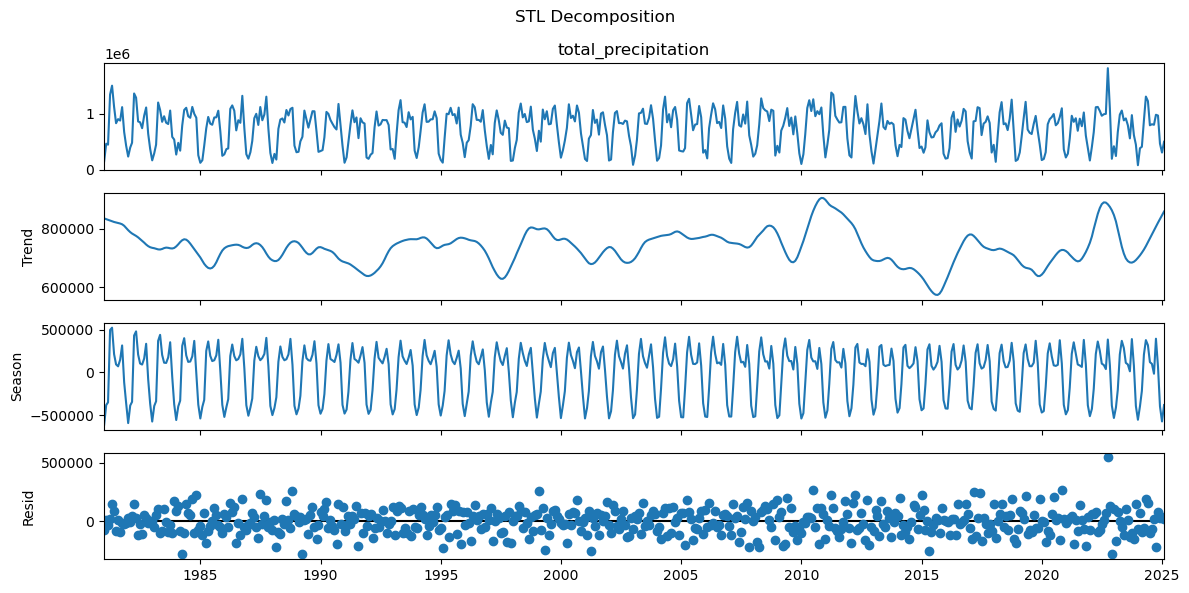

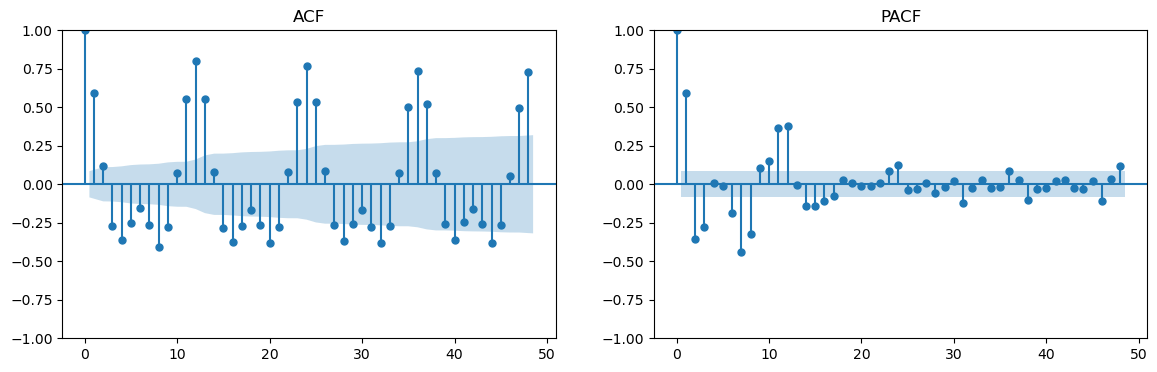

In [2]:
# GPU‐aware + RAM‐optimized pipeline con saneamiento de datos

import os
import warnings

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    ConvLSTM2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")

# 1) Configurar GPU y mixed precision (opcionales)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    device = '/GPU:0'
    print("✅ GPU habilitada, memory_growth ON")
else:
    device = '/CPU:0'
    print("ℹ️ No se detectó GPU, usando CPU")

# Forzamos float32 para evitar problemas de dtype
mixed_precision.set_global_policy('float32')

# 2) Rutas y carga de datos
DATA_PATH  = data_file
MODEL_PATH = model_output_dir
os.makedirs(MODEL_PATH, exist_ok=True)

# Carga de la serie
ds     = xr.open_dataset(DATA_PATH)
precip = ds['total_precipitation'].sum(dim=['latitude','longitude']).to_series()

# 3) Visualización rápida
plt.figure(figsize=(12,4))
precip.plot(title='Monthly Global Precipitation')
plt.ylabel('mm'); plt.grid(); plt.show()

# 4) STL + ACF/PACF
res = STL(precip, seasonal=13).fit()
fig = res.plot(); fig.set_size_inches(12,6)
plt.suptitle('STL Decomposition'); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,2,figsize=(14,4))
plot_acf(precip, lags=48, ax=axes[0]); axes[0].set_title('ACF')
plot_pacf(precip, lags=48, ax=axes[1]); axes[1].set_title('PACF')
plt.show()

## Conclusiones y recomendaciones de ventana de entrenamiento

A partir del análisis de la serie temporal y las funciones ACF/PACF, se extraen las siguientes conclusiones y pautas para diseñar la ventana de entrada de un modelo que prediga 12 meses por delante:

### 1. Comportamiento de la serie

- **Tendencia**  
  Ligera caída hasta mediados de los 90 ’s, posterior estabilización y repunte en los últimos años.

- **Estacionalidad**  
  Ciclo anual muy marcado, con amplitud aproximada de ± 400 000 mm.

- **Residuo**  
  Ruido estacionario con variaciones dentro de ± 100 000 mm.

### 2. Dependencias temporales (ACF / PACF)

| Lag  | ACF     | PACF    |
|------|---------|---------|
| 1    | ~ 0.80  | corte   |
| 2–4  | moderado descenso ↘︎  | valores residuales insignificantes |
| 12   | ~ 0.75  | refuerzo ~ 0.35 |
| 24, 36 | ≈ 0.50–0.70 | débiles  |

### 3. Recomendaciones de ventana de entrada

Para capturar tanto la **dependencia inmediata** como la **estacionalidad anual**, se recomienda una ventana deslizante que incluya:

1. **Lags cortos** (dependencia inmediata):  
   – Meses 1–4 anteriores  
2. **Lags estacionales** (dependencia anual):  
   – Meses 12, 24 y 36 anteriores  

Además, para predecir eficientemente **12 meses por delante**, es aconsejable usar al menos **36–48 meses** de historia como entrada:

```python
window_size = 36  # ó 48 para mayor contexto
features = [
    series.shift(1), series.shift(2), series.shift(3), series.shift(4),
    series.shift(12), series.shift(24), series.shift(36)
]


Loading data from ../data/output/complete_dataset_with_features.nc...
Searching best window for each model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 416, number of used features: 10
[LightGBM] [Info] Start training from score -0.000953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

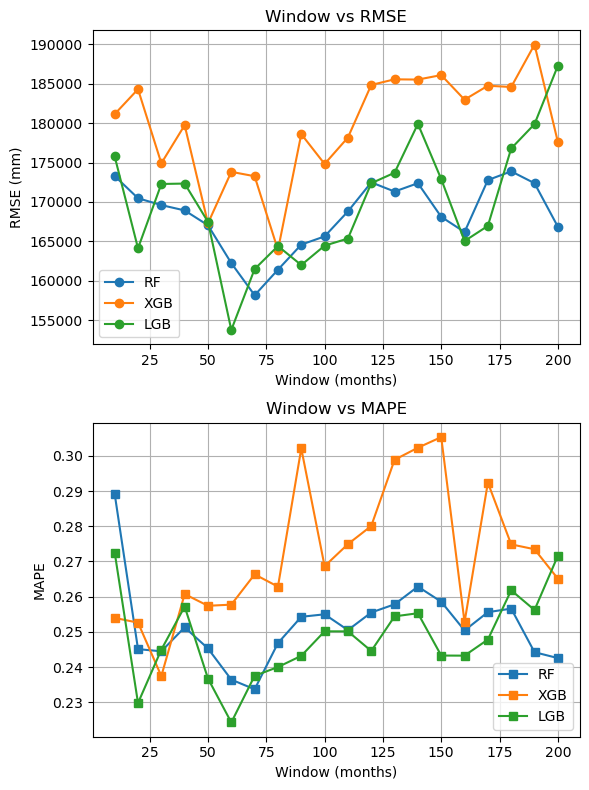

Best windows (by RMSE): {'RF': 70, 'XGB': 80, 'LGB': 60}
Using window=70 for CNN/ConvLSTM
Grid search CNN hyperparams...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7001 - mae: 0.6775 - mape: 153.7696 - val_loss: 0.4459 - val_mae: 0.5189 - val_mape: 113.6776
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3478 - mae: 0.4826 - mape: 132.7761 - val_loss: 0.3540 - val_mae: 0.4311 - val_mape: 79.6455
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2285 - mae: 0.3844 - mape: 127.6845 - val_loss: 0.3049 - val_mae: 0.4049 - val_mape: 83.0813
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2230 - mae: 0.3847 - mape: 158.3206 - val_loss: 0.3189 - val_mae: 0.4497 - val_mape: 112.5465
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2366 - mae: 0.3883 - mape: 179.2329 - val_loss: 0.3132 - val_mae: 0.4353 - val_mape: 98.2922
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2327 - mae: 0.3856 - mape: 124.6626 - val_loss: 0.28

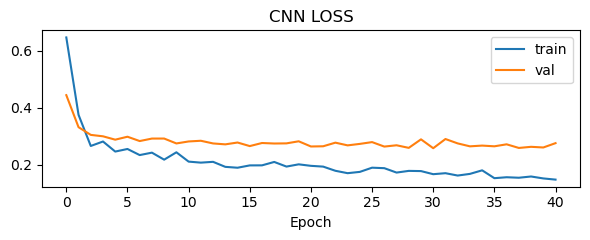

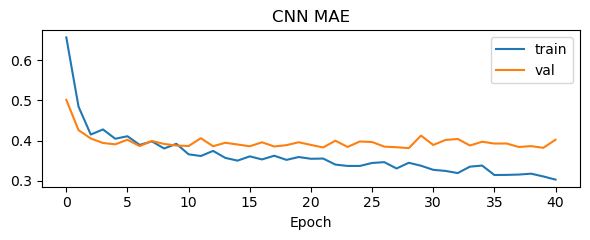

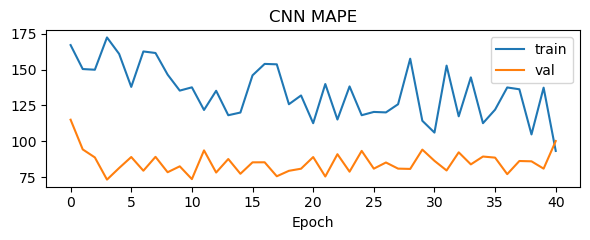

Grid search ConvLSTM hyperparams...
ConvLSTM best -> batch=32, epochs=250, val_MAE(scaled)=0.404, val_MAPE(scaled)=71.205
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
ConvLSTM real -> MAE=257348.28mm, RMSE=314843.22mm, MAPE=68.5%
Plotting ConvLSTM curves...


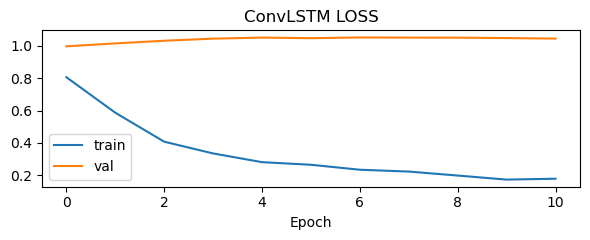

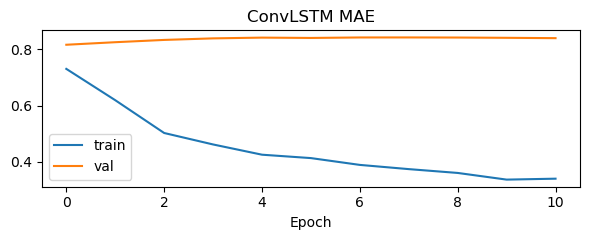

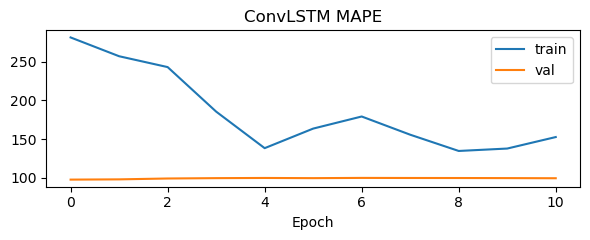


===== Optimal Configuration =====
Window: 70 months
CNN   -> batch=32, epochs=50, RMSE=160033.31mm, MAPE=24.5%
ConvLSTM -> batch=32, epochs=250, RMSE=314843.22mm, MAPE=68.5%
RF R² (window=70): 0.764
XGB R² (window=80): 0.752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7543
[LightGBM] [Info] Number of data points in the train set: 376, number of used features: 60
[LightGBM] [Info] Start training from score 0.000281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [3]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense,
    ConvLSTM2D, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping

# ─── CONFIG ────────────────────────────────────────────────────────────────────
warnings.filterwarnings('ignore')
mixed_precision.set_global_policy('float32')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus: tf.config.experimental.set_memory_growth(g, True)
    device = '/GPU:0'
else:
    device = '/CPU:0'

# Paths
data_path = Path(BASE_PATH)/'data'/'output'/'complete_dataset_with_features.nc'
print(f"Loading data from {data_path}...")
ds = xr.open_dataset(data_path)

# build global precip time series
ts = ds['total_precipitation'].sum(dim=['latitude','longitude']).to_series()

# ─── HELPERS ────────────────────────────────────────────────────────────────────
def create_supervised(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series.iloc[i-window:i].values)
        y.append(series.iloc[i])
    return np.array(X), np.array(y)

def scale_split(X, y, test_size=0.2):
    n = len(X)
    split = int(n*(1-test_size))
    sx = StandardScaler().fit(X.reshape(-1,1))
    sy = StandardScaler().fit(y.reshape(-1,1))
    Xs = sx.transform(X.reshape(-1,1)).reshape(X.shape)
    ys = sy.transform(y.reshape(-1,1)).reshape(-1)
    return Xs[:split], Xs[split:], ys[:split], ys[split:], sx, sy

# ─── 1) WINDOW SEARCH con RF/XGB/LGB ──────────────────────────────────────────────
windows = list(range(10, 201, 10))
models_w = {
    'RF': RandomForestRegressor(random_state=42),
    'XGB': XGBRegressor(use_label_encoder=False, eval_metric='rmse'),
    'LGB': LGBMRegressor()
}
errors_w = {name: {} for name in models_w}
print("Searching best window for each model...")
for name, model in models_w.items():
    for w in windows:
        Xw, yw = create_supervised(ts, w)
        Xtr, Xv, ytr, yv, sx, sy = scale_split(Xw, yw)
        model.fit(Xtr, ytr)
        ypred = model.predict(Xv)
        # inverse-scale to mm
        yv_mm   = sy.inverse_transform(yv.reshape(-1,1)).ravel()
        ypred_mm= sy.inverse_transform(ypred.reshape(-1,1)).ravel()
        errors_w[name][w] = {
            'RMSE': np.sqrt(mean_squared_error(yv_mm, ypred_mm)),
            'MAPE': mean_absolute_percentage_error(yv_mm, ypred_mm)
        }

# Plot errors vs window
fig, axes = plt.subplots(2, 1, figsize=(6,8))
for name in models_w:
    rmse_vals = [errors_w[name][w]['RMSE'] for w in windows]
    mape_vals = [errors_w[name][w]['MAPE'] for w in windows]
    axes[0].plot(windows, rmse_vals, 'o-', label=name)
    axes[1].plot(windows, mape_vals, 's-', label=name)
axes[0].set(title='Window vs RMSE', xlabel='Window (months)', ylabel='RMSE (mm)')
axes[0].grid(True)
axes[1].set(title='Window vs MAPE', xlabel='Window (months)', ylabel='MAPE')
axes[1].grid(True)
for ax in axes: ax.legend()
plt.tight_layout(); plt.show()

# Select best window per model by RMSE
best_window = {
    name: min(errors_w[name], key=lambda w: errors_w[name][w]['RMSE'])
    for name in models_w
}
print("Best windows (by RMSE):", best_window)

# Use RF best window for deep models
W = best_window['RF']
print(f"Using window={W} for CNN/ConvLSTM")
X, y = create_supervised(ts, W)
Xtr, Xv, ytr, yv, sx, sy = scale_split(X, y)

# ─── 2) BUILD CNN & ConvLSTM ────────────────────────────────────────────────────
def build_cnn(w, lr=1e-3, dropout=0.2):
    m = Sequential([
        Input((w,1)),Conv1D(32,3,activation='relu',padding='same'),MaxPooling1D(2),Dropout(dropout),
        Conv1D(64,3,activation='relu',padding='same'),MaxPooling1D(2),Dropout(dropout),
        Flatten(),Dense(32,'relu'),Dropout(dropout),Dense(1,'linear')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr),loss='mse',metrics=['mae','mape'])
    return m

def build_convlstm(w, lr=1e-3, dropout=0.2):
    m = Sequential([
        Input((1,w,1,1)),ConvLSTM2D(32,(1,1),activation='relu',return_sequences=False),
        BatchNormalization(),Dropout(dropout),Flatten(),Dense(32,'relu'),Dropout(dropout),Dense(1,'linear')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr),loss='mse',metrics=['mae','mape'])
    return m

# ─── 3) KERAS LEARNING CURVES ─────────────────────────────────────────────────────
def plot_keras(history, name):
    for metric in ('loss','mae','mape'):
        if metric in history.history:
            plt.figure(figsize=(6,2.5))
            plt.plot(history.history[metric],label='train')
            plt.plot(history.history[f'val_{metric}'],label='val')
            plt.title(f'{name} {metric.upper()}');plt.xlabel('Epoch')
            plt.legend();plt.tight_layout();plt.show()

# hyperparam grid
epochs_list = [50,100,150,200,250]
batch_sizes = [16,32,64,128,256]

# CNN grid
results_cnn = []
print("Grid search CNN hyperparams...")
for bs in batch_sizes:
    for ep in epochs_list:
        with tf.device(device):
            cnn = build_cnn(W)
            h = cnn.fit(
                Xtr[...,None], ytr,
                validation_data=(Xv[...,None], yv),
                epochs=ep, batch_size=bs,
                callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)],
                verbose=1
            )
        # record best scaled MAE/MAPE
        results_cnn.append((bs, ep,
                            min(h.history['val_mae']),
                            min(h.history['val_mape'])))
# select by MAE
bs_cnn, ep_cnn, mae_cnn_s, mape_cnn_s = min(results_cnn, key=lambda x: x[2])
print(f"CNN best -> batch={bs_cnn}, epochs={ep_cnn}, val_MAE(scaled)={mae_cnn_s:.3f}, val_MAPE(scaled)={mape_cnn_s:.3f}")

# retrain best CNN and compute mm metrics
with tf.device(device):
    best_cnn = build_cnn(W)
    best_cnn.fit(
        Xtr[...,None], ytr,
        validation_data=(Xv[...,None], yv),
        epochs=ep_cnn, batch_size=bs_cnn,
        callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)],
        verbose=1
    )
y_pred_scaled = best_cnn.predict(Xv[...,None]).ravel()
yv_mm   = sy.inverse_transform(yv.reshape(-1,1)).ravel()
ypred_mm= sy.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
mae_cnn_mm  = mean_absolute_error(yv_mm, ypred_mm)
rmse_cnn_mm = np.sqrt(mean_squared_error(yv_mm, ypred_mm))
mape_cnn_mm = mean_absolute_percentage_error(yv_mm, ypred_mm)
print(f"CNN real -> MAE={mae_cnn_mm:.2f}mm, RMSE={rmse_cnn_mm:.2f}mm, MAPE={mape_cnn_mm*100:.1f}%")
print("Plotting CNN curves...")
plot_keras(best_cnn.history, 'CNN')

# ConvLSTM grid
results_cl = []
print("Grid search ConvLSTM hyperparams...")
for bs in batch_sizes:
    for ep in epochs_list:
        with tf.device(device):
            cl = build_convlstm(W)
            h = cl.fit(
                Xtr.reshape(-1,1,W,1,1), ytr,
                validation_data=(Xv.reshape(-1,1,W,1,1), yv),
                epochs=ep, batch_size=bs,
                callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)],
                verbose=0
            )
        results_cl.append((bs, ep,
                           min(h.history['val_mae']),
                           min(h.history['val_mape'])))
bs_cl, ep_cl, mae_cl_s, mape_cl_s = min(results_cl, key=lambda x: x[2])
print(f"ConvLSTM best -> batch={bs_cl}, epochs={ep_cl}, val_MAE(scaled)={mae_cl_s:.3f}, val_MAPE(scaled)={mape_cl_s:.3f}")

# retrain best ConvLSTM and compute mm metrics
with tf.device(device):
    best_cl = build_convlstm(W)
    best_cl.fit(
        Xtr.reshape(-1,1,W,1,1), ytr,
        validation_data=(Xv.reshape(-1,1,W,1,1), yv),
        epochs=ep_cl, batch_size=bs_cl,
        callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)],
        verbose=0
    )
y_pred_s = best_cl.predict(Xv.reshape(-1,1,W,1,1)).ravel()
ypred_mm_cl = sy.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
mae_cl_mm  = mean_absolute_error(yv_mm, ypred_mm_cl)
rmse_cl_mm = np.sqrt(mean_squared_error(yv_mm, ypred_mm_cl))
mape_cl_mm = mean_absolute_percentage_error(yv_mm, ypred_mm_cl)
print(f"ConvLSTM real -> MAE={mae_cl_mm:.2f}mm, RMSE={rmse_cl_mm:.2f}mm, MAPE={mape_cl_mm*100:.1f}%")
print("Plotting ConvLSTM curves...")
plot_keras(best_cl.history, 'ConvLSTM')

# ─── 4) SUMMARY ─────────────────────────────────────────────────────────────────
print("\n===== Optimal Configuration =====")
print(f"Window: {W} months")
print(f"CNN   -> batch={bs_cnn}, epochs={ep_cnn}, RMSE={rmse_cnn_mm:.2f}mm, MAPE={mape_cnn_mm*100:.1f}%")
print(f"ConvLSTM -> batch={bs_cl}, epochs={ep_cl}, RMSE={rmse_cl_mm:.2f}mm, MAPE={mape_cl_mm*100:.1f}%")

# ─── 5) TRAINING WITH OPTIMAL PARAMETERS ─────────────────────────────────────────────────────────────────
from sklearn.metrics import r2_score

# ——— RF R² —————————————————————————————————————————————————————————————
W_rf = best_window['RF']
X_rf, y_rf = create_supervised(ts, W_rf)
Xtr_rf, Xv_rf, ytr_rf, yv_rf, sx_rf, sy_rf = scale_split(X_rf, y_rf)
rf_final = RandomForestRegressor(random_state=42)
rf_final.fit(Xtr_rf, ytr_rf)
pred_rf = rf_final.predict(Xv_rf)
r2_rf = r2_score(yv_rf, pred_rf)
print(f"RF R² (window={W_rf}): {r2_rf:.3f}")

# ——— XGB R² ————————————————————————————————————————————————————————————
W_xgb = best_window['XGB']
X_xgb, y_xgb = create_supervised(ts, W_xgb)
Xtr_xgb, Xv_xgb, ytr_xgb, yv_xgb, sx_xgb, sy_xgb = scale_split(X_xgb, y_xgb)
xgb_final = XGBRegressor(use_label_encoder=False, eval_metric='rmse')
xgb_final.fit(Xtr_xgb, ytr_xgb)
pred_xgb = xgb_final.predict(Xv_xgb)
r2_xgb = r2_score(yv_xgb, pred_xgb)
print(f"XGB R² (window={W_xgb}): {r2_xgb:.3f}")

# ——— LGB R² ————————————————————————————————————————————————————————————
W_lgb = best_window['LGB']
X_lgb, y_lgb = create_supervised(ts, W_lgb)
Xtr_lgb, Xv_lgb, ytr_lgb, yv_lgb, sx_lgb, sy_lgb = scale_split(X_lgb, y_lgb)
lgb_final = LGBMRegressor()
lgb_final.fit(Xtr_lgb, ytr_lgb)
pred_lgb = lgb_final.predict(Xv_lgb)
r2_lgb = r2_score(yv_lgb, pred_lgb)
print(f"LGB R² (window={W_lgb}): {r2_lgb:.3f}")

# ——— CNN R² ————————————————————————————————————————————————————————————
# Use the same yv_mm and ypred_mm you computed above
r2_cnn = r2_score(yv_mm, ypred_mm)
print(f"CNN R² (window={W}): {r2_cnn:.3f}")

# ——— ConvLSTM R² ——————————————————————————————————————————————————————
r2_cl = r2_score(yv_mm, ypred_mm_cl)
print(f"ConvLSTM R² (window={W}): {r2_cl:.3f}")


### 4. Decisión final

Se recomienda implementar un modelo que utilice una ventana de entrada de **48 meses** con las **7 features** seleccionadas (lags 1–4, 12, 24, 36). Esto permitirá capturar tanto las dependencias inmediatas como las estacionales, optimizando la predicción de **12 meses por delante**. Se hacen las modificaciones en el script _data/transformation/update/dataset_update.py_ de este repositorio.

Teniendo en cuenta los modelos específicos las ventanas de entrada pueden variar de 60 hasta 80 meses, por lo que se recomienda ajustar la ventana de entrada según el modelo a utilizar.